# Monte carlo simulations of monomers and polymers
Sofus Buskoven, Emil Kofoed & Christoffer Røneid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, float64,vectorize
import statistics as st #importing the necessary libraries


# Monomers


The cells of a multicellular organism are built up by different types of organelles. These organelles can be divided into two sub-categories, membrane-bound and membrane-less organelles. Our goal is to study the membrane-less organelles and through Monte Carlo-simulations look at how different values for the multivalency and temperature affect the formation of membrane-less organelles. The organelles are built up by different biopolymers which again are built up by monomers who form covalent bonds with eachother. There are several modes of intermolecular interaction between these polymers and monomers, however we are only going to consider the electrostatic interactions between them. 

The first part will look at how a system of monomers behave at different temperatures, and how they move around over time to increase their connectivity with other oppositely charged monomers. We assign each monomer with a positive or negative elementary charge While the second part will study how polymers move around at different temperatures and over time to increase their connectivity with oppositely charged polymers. We will modell the movement of each polymer two different ways, rigid move and flexible move. This aims to illustrate the impact of polymers being flexible in the formation of clusters. 

In order to best simulate this movement we will use a Monte Carlo method where we randomly move a monomer, and later a polymer, then calculate the energy in the grid before and after the move. There are two different conditions that can make a monomer realize the move. The difference in energy between the old and the new grid is below zero, which will always result in a move. To account for thermal fluctuations and the impact of the temperature in the system we compare $\exp(-\beta \Delta E)$ with a random decimal number between $0$ and $1$. If the $\exp(-\beta \Delta E)$ is larger than the decimal number the move is realized even if it is energietically unfavourable.  



## The topology of the system

We represent the system on a $N \times N$ grid with periodic boundary conditions. This means that the left most coloum and row neighbours the right most coloum and row. This is a trick to prevent the simulations from being affected by 'surface effect'. In other words, the grid is like a torus, and not a 2D-grid.

In [ ]:
@njit
def generate_grid_of_monomers(grid_size,monomers):
    """
    grid_size: Size of the grid.
    monomers: Number of positive/negative monomers.

    Adds monomers in random cells in an 2D array of zeroes.

    Return: A grid filled with positively and negatively charged monomers.
    """
    grid = np.zeros((grid_size,grid_size), dtype=np.dtype('i2')) # Create a 2D array of zeroes
    i = 1
    monomers += 1
    assert(grid_size**2 > monomers*2) # Check if the grid can hold the amount of monomers
    while(i < (monomers)*2):
        random_pos1 = np.random.randint(grid_size)
        random_pos2 = np.random.randint(grid_size)
        if(grid[random_pos1][random_pos2] == 0):
            grid[random_pos1][random_pos2] = (i % monomers) if i >= monomers else -(i % monomers) # Place a negative or positive monomer depending on the iteration
            i += 1
    return grid

In [ ]:
def visualize_grid(grid, title, fig, mer_type = 1):
    '''
    grid: Grid of monomers or polymers
    title: Title of the plot
    fig: Figure number
    mer_type: Input to differentiate between monomers and polymers

    Function used to visualize the grid of monomers and polymers. 
    The last argument decides if it colours as polymer, monomer or cluster grid.

    Where the Polymer colouring is more gradient 
    '''

    if(mer_type == 1):

        plt.pcolormesh(grid[::-1,],vmin=-1,vmax=1,cmap= "coolwarm")
        plt.axis("off")
        plt.title(title)
        plt.figure(fig)

    elif(mer_type == 2):
        plt.pcolormesh(grid[::-1,],cmap="PiYG")
        plt.axis("off")
        plt.title(title)
        plt.colorbar()
        plt.figure(fig)
 

    elif(mer_type == 3):
     
        plt.pcolormesh(grid[::-1])
        plt.axis("off")
        plt.title(title)
        plt.colorbar()
        plt.figure(fig)



In [ ]:
@njit
def nearest_monomer_neighbour(grid_size,i,j):
    ''' 
    grid_size: The length and height of the NxN grid
    i: The x-coordinate corresponding to the i-th column starting at 0 
    j: The y-coordinate corresponding to the j-th row starting at 0 

    Takes an input of x- and y-coordinates and finds the the 4 neighbouring cells in the grid. This takes in account that the grid wraps like a torus.

    Return: 2-Dimensional array containing the coordinates of the cells adjacent to the edges of the cell at coordinates (i,j)
    '''
    return np.array([[(i-1)%grid_size,j],[i,(j+1)%grid_size],[(i+1)%grid_size,j],[i,(j-1)%grid_size]], dtype=np.dtype('i2'))

In [ ]:
@njit
def energy_in_grid(monomer_grid,relative_permittivity,monomer_distance):
    '''
    monomer_grid: Grid of monomers
    relative_permittivity: The relative permitivity of the solvent the monomers are placed in
    monomer_distance: Distance between monomers, also known as a

    Uses coloumbs law modified for our system to calculate the total energy of the system at a given configuration given by monomer_grid

    Return: The energy of a system at a given configuration of the grid of monomers. 
    '''
    energy = 0
    alpha = (1.6e-19)**2 / (4*np.pi*8.85e-12*relative_permittivity*(monomer_distance)**2) # Defining the Alpha constant
    for i in range(monomer_grid[0].size):
        for j in range(monomer_grid[0].size): # Nested for-loop to check each coordinate in the grid. 
            if monomer_grid[i][j] != 0:
                nearest_neighbour = nearest_monomer_neighbour(monomer_grid[0].size,i,j) # Extracting neighbours of a monomer
                for coord in nearest_neighbour:
                    if monomer_grid[coord[0]][coord[1]] != 0: # If the nearest neighbours are monomers add their energy-contribution to the energy-variable
                        energy += np.sign(monomer_grid[coord[0]][coord[1]]*monomer_grid[i][j])*alpha # np.sign() returns 1 for positive and -1 for negative values
    return energy/2 # We have to take into account that the energy between two monomers are counted twice

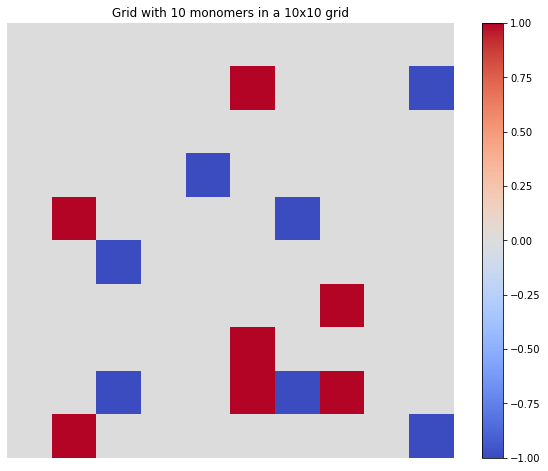

The energy in the grid above is -5.578745581360779e-21


In [ ]:
grid_disp = generate_grid_of_monomers(10,7)
plt.rcParams["figure.figsize"] = (10,8)
visualize_grid(grid_disp,"Grid with 10 monomers in a 10x10 grid",1,1)
plt.colorbar()
plt.show()
print(f"The energy in the grid above is {energy_in_grid(grid_disp,78,23e-6)}")

The figure illustrates a system with a random configuration of 20 monomers in a 10 by 10 grid, where the colour blue represents a negatively charged monomer, and red a positively charged polymer. 

### Simulating the behaviour of monomer interactions

We are now going to use a monte carlo algorithm and the law of large numbers to somewhat mimic the behaviour of monomers when evolved over time with a reasonable distance between each monomer. The monte carlo algorithm is implemented below.

In [ ]:
@njit
def move_monomer(grid,monomer,direction):
    """
    grid: Grid of monomers.
    monomer: A specific monomer.
    direction: The direction we want to move the polymer given as a value between 0 and 3

    Places the monomer in the new position if the move is legal (the position is an empty cell).

    Return: A grid with the monomer moved.
    """
    grid_copy = grid.copy()
    monomer_coords = np.argwhere(grid == monomer)[0] # Finds the coordinates of the monomer
    grid_size = grid.shape[0]
    neighbour_monomers = nearest_monomer_neighbour(grid_size,monomer_coords[0],monomer_coords[1]) # Finds the neighbour of the monomer
    new_position = neighbour_monomers[direction]
    if (grid[new_position[0]][new_position[1]] == 0.0):
        grid_copy[new_position[0]][new_position[1]] = monomer # Places the monomer at new position
        grid_copy[monomer_coords[0]][monomer_coords[1]] = 0.0 # Erases the monomer from the previous position
    return grid_copy

In [ ]:
@njit
def monte_carlo(grid,max_iter,temperature):
    """
    grid: Grid of monomers.
    max_iter: Number of iterations we are running the simulation.
    temperature: The temperature of the system.

    Pick a random monomer and a random direction.
    Move the random monomer and check the energy in the system.
    Compare the energy of the old and new grid and override the grid if the new energy is lower.
    Take into account thermal fluctiations.

    Return: Grid after a completed monte carlo simulation and an array the corresponding energies for every configuration of the system
    """
    monomers = np.max(grid)
    energy_list = np.zeros(int(max_iter), dtype=np.dtype('f'))
    energy = energy_in_grid(grid,78,23e-6) # Relative permittivity = 78 F/m and monomer distance = 91*10^-6
    energy_list[0] = energy
    for i in range(max_iter):
        random_monomer = np.random.randint(1,monomers+1) * (2 * np.random.randint(0,2) - 1) # Choose a random positive or negative monomer
        random_direction = np.random.randint(0,4)
        new_grid = move_monomer(grid,random_monomer,random_direction) # Function of choice for moving the monomer
        new_energy = energy_in_grid(new_grid,78,23e-6) # Relative permittivity = 78 F/m and monomer distance = 91*10^-6
        if (new_energy < energy):
            grid = new_grid # Override the grid if the new energy is lower
            energy = new_energy
        elif(np.random.random() < np.exp(-1/(1.38e-23*temperature)*(new_energy-energy))): # Simulating thermal fluctuations
            grid = new_grid
            energy = new_energy
        energy_list[i] = energy
    return grid, energy_list

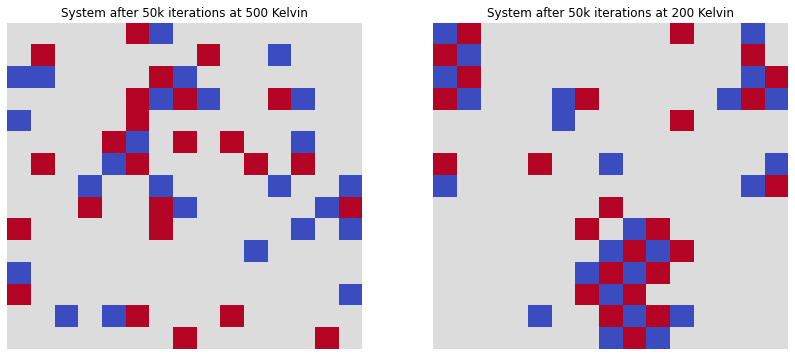

<Figure size 1008x432 with 0 Axes>

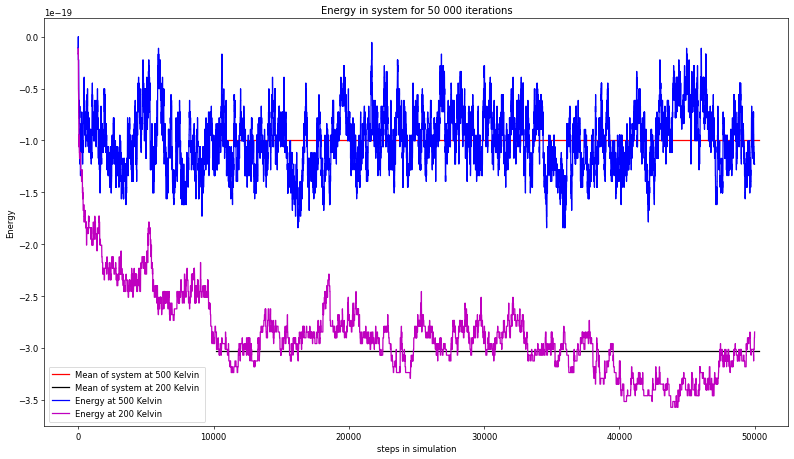

CPU times: user 1.84 s, sys: 0 ns, total: 1.84 s
Wall time: 1.83 s


In [ ]:
test_grid = generate_grid_of_monomers(15,25)
grid_500, e1 = monte_carlo(test_grid,50000,500)
grid_200, e2 = monte_carlo(test_grid,50000,200)
plt.rcParams["figure.figsize"] = (14,6)
plt.subplot(1,2,1)
visualize_grid(grid_500,"System after 50k iterations at 500 Kelvin",1)
plt.subplot(1,2,2)
visualize_grid(grid_200,"System after 50k iterations at 200 Kelvin",2)
np.savez('grid_200.npz',grid_200)
plt.show()


def mean_energy(energy):
    ''' 
    Takes the energy array and slices the first 10 000 entries and returns the mean.
    '''
    array = st.mean(energy[10000:])
    return array

plt.figure(figsize=(16,9), dpi=60)
plt.title("Energy in system for 50 000 iterations")
plt.ylabel("Energy")
plt.xlabel("steps in simulation")
plt.axhline(y = mean_energy(e1), xmin = 0.23,xmax=0.96 ,color = 'r',label = "Mean of system at 500 Kelvin ")
plt.axhline(y = mean_energy(e2), xmin = 0.23,xmax=0.96 ,color = 'black',label = "Mean of system at 200 Kelvin ")
plt.plot(e1,'b',label = "Energy at 500 Kelvin")
plt.plot(e2,'m',label="Energy at 200 Kelvin")
plt.legend()
plt.show()

%time e = grid_500, e1 = monte_carlo(test_grid,50000,500)

The first two figures show the configuraton of the system of monomers at 500 and 200 Kelvin respectively after 50 000 iterations. The plot tells us that systems at lower temperatures have lower energy and also uses longer time before they reach equilibrium. This is because the factor $\beta = \frac{1}{k_b T}$ is smaller at higher temperatures and therefore the probability that $\exp(-\beta \Delta E)$ is larger than som decimal number between 0 and 1 increases. In other words systems with a higher temperature has a higher probability of making energetically unfavourable moves. At som point each system will reach a configuration where the probability that a random move from any monomer will lower the energy in the system is balanced out by the probability that $\exp(-\beta \Delta E)$ is higher than som random decimal number between 0 and 1. Therefore there is a higher probability for systems at a lower temperature to get stuck at a local energy minima. 

For the system at 500 Kelvin this happens just after a few hundred iterations according to the graph above. For the system at 200 kelvin it takes about 10000 iterations. The line through each graph illustrates the mean from 10000 to 50000 iterations.The system at 500 kelvin reaches it's equilibrium state before 10 000 iterations. But to visually illustrate the differences of the two systems the mean is plotted over the same intervall for both systems. We could have calulated the standard deviation and error of the energy and plotted them together with the mean and the energy for 50000 iterations, but since the plots are messy it would affect readability. The system swings around an equilibrium state and we can therefore visually give a good estimation of our unceirtainty by looking at the maxima and minima.  

### The clustering of monomers
Typical behaviour we observe when simulating a grid of monomers is the formation of clusters with many monomers. We will discuss the impact of changing input parameters, namely the temperature. Clustering is interesting to study particularly because later we are going to discuss interactions between polymers, which is essentially a cluster of monomers.

In [ ]:
@njit
def cluster(grid,cluster_id, x,y):
    '''
    grid: Grid of monomers.
    cluster_id: Unique ID for the cluster in question.
    x: x-coordinate of the selected cell.
    y: y-coordinate of the selected cell.

    This function is called on a spot in the grid and changes the value to the cluster ID, it recursively calls itself when it finds a value of -1
    in the nearest neighbour of the current cell.
    '''
    grid_size = grid.shape[0]
    neighbours = nearest_monomer_neighbour(grid_size,x,y)
    for j in range(neighbours.shape[0]): # Iterates through all the neighbours
        if(grid[neighbours[j][0]][neighbours[j][1]] == -1): # Runs if the cell has the arbitrary value -1, this is guaranteed by the function below
            x_new = neighbours[j][0]
            y_new = neighbours[j][1]
            grid[x_new][y_new] = cluster_id # Sets the clustered monomer to the right value
            cluster(grid,cluster_id,x_new,y_new) # Recursively calls itself so that neighbour of every neighbour is included
    
@njit
def cluster_grid(grid):
    """
    grid: Grid of monomers.

    Sets the value of each occupied cell to -1 for simplicity. Then iterates throught the grid and runs the cluster()-function when it encounters
    a new cluster. Each cluster will be assigned a unique positive integer ID.

    Return: A grid where monomers that are clustered have the same value.
    """
    new_grid = grid.copy()
    new_grid = np.sign(new_grid*-new_grid) # Sets all nonzero values to -1
    cluster_id = 1
    for i in range(grid.size):
        x = i % grid.shape[0]
        y = (i-x)//grid.shape[0]
        if (new_grid[x][y] == -1): # If a new cluster is encountered
            new_grid[x][y] = cluster_id # Sets the selected monomer to the current cluster ID because this will not be included in the recursion
            cluster(new_grid,cluster_id,x,y) # Every monomer in the same cluster gets the same ID
            cluster_id += 1
    return new_grid

In [ ]:
@njit
def cluster_size(grid):
    """
    grid: Grid of monomers.

    Makes a 1D array of the grid and increments the value of the array where the index is the cluster ID when it encounters a monomer.
    In practice this will count the size of the clusters.

    Return: An array with the sizes of the clusters.
    """
    cluster_sizes = np.zeros(grid.size, dtype=np.dtype('i2'))
    for i in range(grid.size):
        x = i % grid.shape[0]
        y = (i-x)//grid.shape[0]
        if (grid[x][y] != 0):
            cluster_sizes[grid[x][y]] += 1
    return cluster_sizes[cluster_sizes != 0]

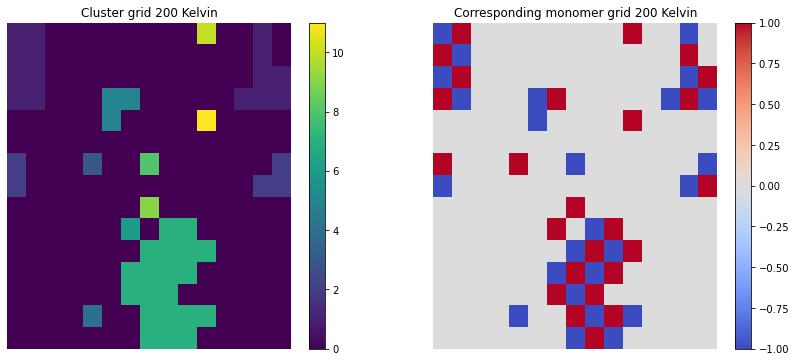

In [ ]:

filenpz = np.load("grid_200.npz")
filenpz.files
grid_from_file = filenpz['arr_0']
plt.rcParams["figure.figsize"] = (14,6)
plt.subplot(1,2,1)
visualize_grid(cluster_grid(grid_from_file),"Cluster grid 200 Kelvin",1,3)
plt.subplot(1,2,2)
visualize_grid(grid_from_file,"Corresponding monomer grid 200 Kelvin",1,1)
plt.colorbar()
plt.show()

Here we have two plots of the same configuration after a monte carlo simulation with 50000 iterations. The rightmost figure is the normal plot of the monomers where we see the negative and positive monomers and to the left we can see the corresponding clustered grid. Each cluster is represented by a different color. 

In [ ]:
@njit
def cluster_size_per_temp(max_iter,grid_size,monomers,temp_low,temp_high,step_size,measurements,temp_number):
    """
    max_iter: Input for calculating the equilibrium steps, t_max.
    grid_size: Size of the grid to simulate.
    monomers: The number of positively charged monomers.
    temp_low: The lowest temperature of the simulation.
    tem_high: The highest temperature of the simulation.
    step_size: Number of monte carlo iterations between each measurement.
    measurements: Number of measurements after reached equilibrium.

    Adds the mean cluster sizes in an array for each measurement, and takes the mean of the cluster size array for each temperature.
    Adds the standard deviation of the average cluster sizes to an array for each measurement. 

    Return: An array with the mean of the mean cluster sizes for each distinct temperature simulation.
    """
    temp_interval = (temp_high-temp_low)//(temp_number-1) # Calculates the interval between the temperatures
    cluster_per_temp = np.zeros(temp_number, dtype=np.dtype('f'))
    cluster_standard_dev = np.zeros(temp_number, dtype=np.dtype('f'))
    for i in range(temp_number):
        temperature = temp_low + i*temp_interval # Sets the right temperature for this iteration
        grid = generate_grid_of_monomers(grid_size,monomers) # Generates a new monomer grid
        clusters = np.zeros(measurements+1, dtype=np.dtype('f'))
        equilibrium_steps = int(max_iter * np.exp(-1/20*(temperature-temp_low))) + 10000 # Calculates the number of steps needed to reach equilibrium
        grid, energies = monte_carlo(grid,equilibrium_steps,temperature) # Run the equilibrium simulation
        clustered_grid = cluster_grid(grid)
        clusters[0] = np.mean(cluster_size(clustered_grid)) # Adds the first mean cluster size to the array
        for n in range(1,measurements+1):
            grid, energies = monte_carlo(grid,step_size,temperature) # Run the simulation with the step_size
            clustered_grid = cluster_grid(grid)
            clusters[n] = np.mean(cluster_size(clustered_grid)) # Adds the mean cluster size to the array
        cluster_per_temp[i] = np.mean(clusters) # Adding the mean of the array containing the mean of the cluster sizes for this temperature
        cluster_standard_dev[i] = np.std(clusters)
    return cluster_per_temp,cluster_standard_dev
        

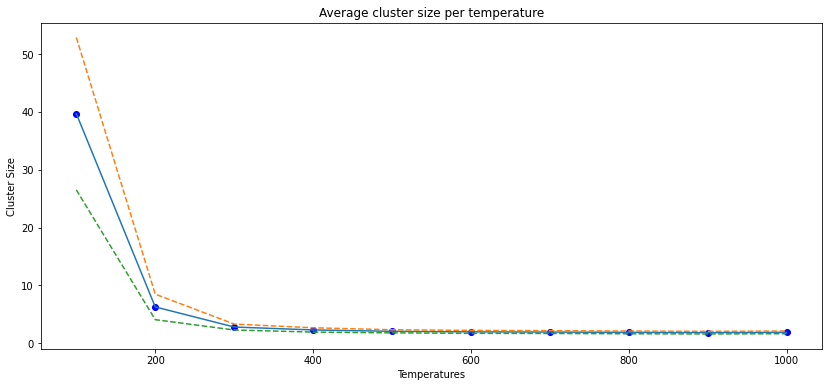

Time with t_max = 5000000 and n = 100
CPU times: user 3min 44s, sys: 328 ms, total: 3min 44s
Wall time: 3min 44s
Time with t_max = 100000 and n = 50
CPU times: user 25.5 s, sys: 40 ms, total: 25.5 s
Wall time: 25.5 s


In [ ]:
# Defining variables for cluster_size_per_temp()-function
N = 15
t_max = 5000000
M = 25
T_l = 100
T_h = 1000
t_r = 1000
n = 100
t_distance = 10








cspt, cspt_stdev = cluster_size_per_temp(t_max,N,M,T_l,T_h,t_r,n,t_distance)
x_vals = np.linspace(100,1000,10)
plt.plot(x_vals,cspt,'bo',label = "Average of the average cluster size")                                              
plt.plot(x_vals,cspt)
plt.plot(x_vals,cspt+cspt_stdev,'--')
plt.plot(x_vals,cspt-cspt_stdev,'--')
plt.title("Average of the average cluster sizes")
plt.xlabel("Temperatures")
plt.ylabel("Cluster Size")
plt.title("Average cluster size per temperature") 
plt.show()
print("Time with t_max = 5000000 and n = 100")
%time e = cluster_size_per_temp(t_max,N,M,T_l,T_h,t_r,n,t_distance)
print("Time with t_max = 100000 and n = 50")
%time e = cluster_size_per_temp(100000,N,M,T_l,T_h,t_r,50,t_distance)




The plot shows the average of the average cluster size per temperature, the dotted lines illustrate the standard deviation of the average of the cluster sizes. Where we first let the simulation run until the system hits equilibrium, and then take 100 measurements of the average cluster size with 1000 iterations between each measurement. We do this for 10 evenly spaced temperatures between 100 Kelvin and 1000 Kelvin. Before we again take the average of the average cluster size. While the average of the average is not equal to $\langle d \rangle$ it is an unbiased estimator of $\langle d \rangle$ and it is safe to use since the amount of monomers and $n$ stays consistent throughout all the measurements. With 100 datapoints for each temperature $\bar d$ is a good estimator for the real value of $\langle d \rangle$. Since the run time with $t_{max} = 100000$, and $n = 50$ was about 26 seconds seconds we increased $t_{max}$ by a factor of 5 and $n$ by a factor of 2. This gives us reasonably accurate results without impacting run time too much. Increasing $t_{max}$ further seems redundant. 

From the plot we see that $\langle d \rangle$ decreases as $T$ increases. This is because of our implementation of thermal fluctuation in the system. Higher temperatures produces higher values for $\exp(-\beta \Delta E)$ and therefore the system has a higher probability of realising an energetically unfavourable move. Which in turn means clustering is less likely to happen at higher temperatures.


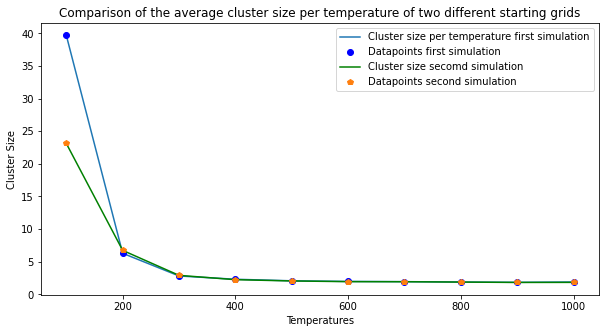

In [ ]:
cspt2, cspt2_stdev = cluster_size_per_temp(t_max,N,M,T_l,T_h,t_r,n,t_distance)
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_vals,cspt,label = "Cluster size per temperature first simulation")
plt.plot(x_vals,cspt,'bo',label = "Datapoints first simulation")
plt.plot(x_vals,cspt2,'green' ,label = "Cluster size secomd simulation")
plt.plot(x_vals,cspt2,'p',label ="Datapoints second simulation")
plt.xlabel("Temperatures")
plt.ylabel("Cluster Size")
plt.title("Comparison of the average cluster size per temperature of two different starting grids")
plt.legend()
plt.show()


From the plot we see that the discrepancy between low temperatures in the two simulations are very large compared to the high temperatures. Since the probability of thermal fluctuations being the cause of monomers moving are lower for systems at lower temperatures the initial grid plays a bigger part in the formation of clusters and their size. From the graph where we compared two systems at 200 Kelvin and 500 Kelvin we can see that at 200 Kelvin the amplitude of the oscillations around the mean are smaller than the amplitudes at 500 Kelvin. This is an indication that a system at low temperatures stays closer to it's equilibrium and therefore the monomers move less after equilibrium is reached. Therefore the initial grid plays a bigger part in the formation of clusters at lower temperatures than at high temperatures. 

# Polymers

We are now done with studying monomers alone, and move over to the world of polymers. Polymers are complex molecules consisting of different monomers, and while they can't move just as freely as monomers alone, they are surprisingly flexible.
For the sake of simplicity we are going to make some assumptions about the polymers. Every polymer will have the same multivalency, which is the number of monomers the polymer is made up of. This is quite unrealistic, but it can give us some good insight in the interactions between polymers nonetheless. The functions we are going to implement for moving the polymers are relatively simple, which has consequenses when looking at the simulation over time, as the flexibility of the polymers decreases drastically with this assumption. We will also look at polymers that never break. The charge of the polymers will be equal to the elementary charge, and there will be the same amount of positively and negatively charged polymers in the system. We are now going to be placing polymers in a grid similar to what we did earlier with monomers.

In [ ]:
@njit
def generate_grid_of_polymers(grid_size,polymers,multivalency):
    '''
    grid_size: Size of the NxN grid.
    polymers:  Number of polymers with a positive and negative charge, total amount is twice the value of this input.
    multivalency: Total number of monomers in each polymer.

    The function takes in the grid size, makes a grid of zeros. 
    Maps the grid to a 1-d array of size grid_size*grid_size. This maps each cell of the grid to an index of the array.
    Creates a copy of the existing grid and the values in it.
    Picks a random starting point that is avaliable for placing a monomer. 
    Saves every position avaliable for placing the next monomer in the polymer by updating the mapped grid array with the index as the position and
    incrementing this array value.
    Whenever a monomer is placed at one of the available positions, this position is removed from the mapped array containing the positions available.
    If the polymer has no more available spots for placing monomers before reaching the needed multivalency, the process will start over.

    Return: Grid of polymers with multivlaency amount of monomers in each polymer. 
    '''

    grid = np.zeros((grid_size,grid_size), dtype=np.dtype(('i2')))
    i = 1
    polymers +=1
    assert(grid_size**2 > polymers*multivalency*2)
    while(i < polymers*2):
        grid_copy = grid.copy()
        mapping_grid = np.zeros(grid_size*grid_size, dtype=np.dtype(('i2'))) # 1-D array that maps every coordinate with a number
        x_cord = np.random.randint(grid_size) # Choose random coordinates
        y_cord = np.random.randint(grid_size) 
        if(grid[x_cord][y_cord] == 0): # If only solvent, place a monomer there
            grid[x_cord][y_cord] = (i%polymers) if i >= polymers else -(i % polymers) # Placing monomer
            placed = 1 # Updating placed count
            while(placed < multivalency):
                neighbours = nearest_monomer_neighbour(grid_size,x_cord,y_cord) # Extract neighbours coordinate
                for el in range(neighbours.shape[0]):
                    mono = neighbours[el]
                    mono_x = mono[0] # Extracting relevant coordinsates for the neighbours 
                    mono_y = mono[1]         
                    if(grid[int(mono_x)][int(mono_y)] == 0): # Checking if the corresponding cell has a monomer there
                        grid_number = mono_y*grid_size + mono_x
                        mapping_grid[int(grid_number)] = 1 # Setting all the cells with an avaliable spot equal to one.
                legal_places = np.argwhere(mapping_grid).T[0]
                if(legal_places.size == 0): # If there are no more legal places for placing monomers start over. 
                    grid = grid_copy
                    i -=1
                    break
                rand_legal = np.random.randint(legal_places.size)
                rand_legal_cord = legal_places[rand_legal]
                x_cord = rand_legal_cord%grid_size
                y_cord = (rand_legal_cord-x_cord)//grid_size
                grid[x_cord][y_cord] = (i%polymers) if i >= polymers else -(i % polymers) # Placing monomer at the given avaliable spot
                mapping_grid[rand_legal_cord] = 0
                placed += 1
            i += 1
    return grid

In [ ]:
@njit
def energy_in_polymer_grid(polymer_grid,relative_permittivity,monomer_distance):
    '''
    monomer_grid: Grid of polymers.
    relative_permittivity: The relative permitivity of the solvent the monomers are placed in.
    monomer_distance: Distance between monomers.

    Uses coloumbs law modified for our system to calculate the total energy of the system at a given configuration given by monomer_grid.
    Only counts interactions between different polymers. The interactions of between monomers of the same polymer are neglected.

    Return: The energy of a system at a given configuration of the grid of polymers. 
    '''
    energy = 0
    alpha = (1.6e-19)**2 / (4*np.pi*8.85e-12*relative_permittivity*(monomer_distance)**2) # Defining the Alpha constant
    for i in range(polymer_grid[0].size):
        for j in range(polymer_grid[0].size):
            if polymer_grid[i][j] != 0:
                nearest_neighbour = nearest_monomer_neighbour(polymer_grid[0].size,i,j)
                for coord in nearest_neighbour:
                    if polymer_grid[coord[0]][coord[1]] != 0 and polymer_grid[coord[0]][coord[1]] != polymer_grid[i][j]: # We don't count interactions between monomers in the same polymer
                        energy += np.sign(polymer_grid[coord[0]][coord[1]]*polymer_grid[i][j])*alpha # np.sign() returns 1 for positive and -1 for negative values
    return energy/2 # We have to take into account that the energy between two monomers are counted twice

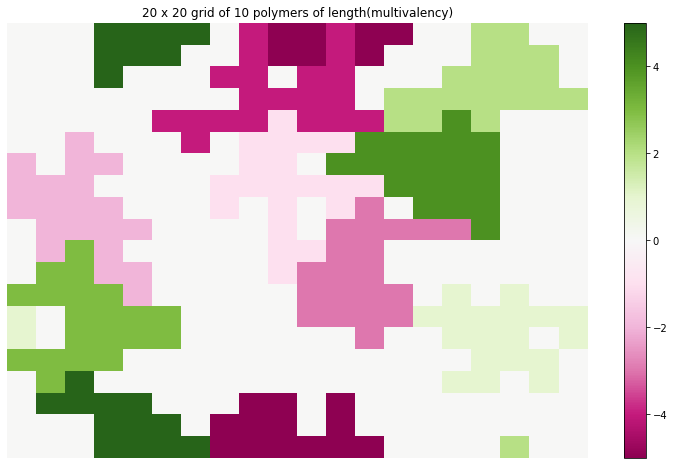

In [ ]:
plt.rcParams["figure.figsize"] = (13,8)
gr = generate_grid_of_polymers(20,5,20)
visualize_grid(gr,"20 x 20 grid of 10 polymers of length(multivalency)",1,2)

The grid above shows 10 polymers each with mutivalency 20. Each polymer is represented with a different color, the negative polymers with shades of pink, and the positive shades of green.

### Simulating the interaction between polymers

We are now going to implement the monte carlo algorithm just like what we did before with monomers. Some slight modifications to the functions has to be made so that they can properly simulate polymers instead of monomers. For instance we have to change the energy-function so that the interaction between monomers of the same polymers do not count toward the total energy of the system. We are also going to implement two separate functions made for moving polymers with different logic. The first is rigid_move() which moves the whole polymer as one unit. This will only be legal if there are no other polymers blocking in the moving direction. The other is called medium_flex_move() where we move each row/column of the polymer individually. If the polymer breaks during this operation, the move is illegal and won't be accepted. These are used as an input in the monte carlo algorithm and will be compared below. All necessary functions are implemented below, including the monte carlo algorithm and the moving functions, along with several assisting functions.

In [ ]:
@njit
def polymer_length(grid,polymer,x,y,length):
    """
    grid: Grid of polymers.
    polymer: A specific polymer.
    x: x-coordinate of grid cell.
    y: y-coordinate of grid cell.
    length: The counted length of the polymer.

    Recursive function that counts the length of a given polymer by finding the neighbour of each neighbour with the correct polymer ID.
    This function works quite similar to the cluster()-function.
    """
    grid_size = grid.shape[0]
    neighbours = nearest_monomer_neighbour(grid_size,x,y)
    for j in range(neighbours.shape[0]): # Iterating through all neighbours
        if(grid[neighbours[j][0]][neighbours[j][1]] == polymer): # Will only count if the neighbour is of the given polymer
            x_new = neighbours[j][0]
            y_new = neighbours[j][1]
            length += 1 # The counting variable is incremented
            grid[x_new][y_new] = 0 # We need to set the already counted grid cell to a value different than the polymer ID so it won't be counted multiple times
            polymer_length(grid,polymer,x_new,y_new,length) # Recursive call to include the whole polymer

@njit
def is_polymer_whole(grid,polymer):
    """
    grid: Grid of polymers.
    polymer: A specific polymer.

    Finds the indices of the given polymer and counts the multivalency of the polymer using the recursive polymer_length()-function.

    Return: A boolean which is False if the polymer is broken, and True if it is whole.
    """
    grid_copy = grid.copy() # We use a copy of the grid because we are going to modify it
    polymer_coords = np.argwhere(grid == polymer) # Finding the grid indices of the polymer 
    multivalency = polymer_coords.shape[0]
    grid_copy[polymer_coords[0][0],polymer_coords[0][1]] = 0 # Sets the value of the selected to a different value than the polymer ID so it won't be counted multiple times
    polymer_count = np.array([1]) # Numpy arrays passes by reference so the value will be incremented globally
    polymer_length(grid_copy,polymer,polymer_coords[0][0],polymer_coords[0][1],polymer_count) # This function counts the clustered monomers with the same value
    if (polymer_count == multivalency):
        return True
    else:
        return False

In [ ]:
@njit
def polymer_rigid_move(grid,polymer,direction):
    """
    grid: Grid of polymers.
    polymer: A specific polymer.
    direction: The direction we want to move the polymer given as a value between 0 and 3

    Finds the coordinates of the given polymer and incrementing or decrementing the coordinates depending on the direction input.
    When the new coordinates is found, the old polymer is erased from the grid, and then added back in the new position. 
    Will only move the polymer if the move is legal and doesn't collide with another polymer.

    Return: A grid with the moved polymer if the given move was legal.
    """
    grid_copy = grid.copy()
    monomer_coords = np.argwhere(grid==polymer).T # This is a 2D array with the x coordinates in the first array and y coordinates in the second array
    new_coords= monomer_coords.copy()
    direction_add = np.array([1,-1,-1,1]) # Indexed to the corresponding direction
    if (direction >= 2):
        new_coords[0] += direction_add[direction] # This is if the movement is vertical
    else:
        new_coords[1] += direction_add[direction] # This is if the movement is horizontal
    new_coords = new_coords % grid.shape[0] # Fixing the boundary conditions
    for i in range(new_coords.T.shape[0]): # Iterating throught the coordinates of the polymer
        coords = new_coords.T[i] 
        old_coords = monomer_coords.T[i]
        if (grid[coords[0]][coords[1]] == 0 or grid[coords[0]][coords[1]] == polymer):
            grid_copy[old_coords[0]][old_coords[1]] = 0 # Erasing the polymer from the old position
        else:
            return grid # Returns the initial grid if the move is illegal
    for coords2 in new_coords.T:
        grid_copy[coords2[0]][coords2[1]] = polymer # Placing the polymer at the moved location
    return grid_copy

In [ ]:
@njit
def polymer_medium_flex_move(grid,polymer,direction):
    """
    grid: Grid of polymers.
    polymer: A specific polymer.
    direction: The direction we want to move the polymer given as a value between 0 and 3

    Finds the polymer in question and change the value of each row or column (depending on move direction), and moves a polymer row by row
    (or column by column). The function checks if the move breaks the polymer, and rejects the move if the polymer is incoherent.
    
    Return: Grid with the polymer moved if the move is legal.
    """
    grid_copy = grid.copy()
    new_id = np.max(grid) + 1 # The row/column ID must have a higher value than the largest polymer value else the logic might break
    polymer_coords = np.argwhere(grid == polymer)
    if (direction >= 2): # We have to move each column if move direction is up/down, or each row if move direction is left/right
        for column in range(np.min(polymer_coords.T[1]),np.max(polymer_coords.T[1])+1):
            grid_copy[:,column] = grid_copy[:,column]*new_id # Each column will now have a uniqe ID for a unique polymer
            grid_copy = polymer_rigid_move(grid_copy,polymer*new_id,direction) # We move only the values that both belong to the polymer and column
            grid_copy[:,column] = grid_copy[:,column]//new_id # The values are changed back to normal
            new_id += 1 # Increment is important so we can differentiate between columns
    else:
        for row in range(np.min(polymer_coords.T[0]),np.max(polymer_coords.T[0])+1):
            grid_copy[row,:] = grid_copy[row,:]*new_id # Each row will now have a uniqe ID for a unique polymer
            grid_copy = polymer_rigid_move(grid_copy,polymer*new_id,direction) # We move only the values that both belong to the polymer and row
            grid_copy[row,:] = grid_copy[row,:]//new_id # The values are changed back to normal
            new_id += 1 # Increment is important so we can differentiate between rows
    if (not is_polymer_whole(grid_copy,polymer)): # Check if the polymer is broken or not
        return grid
    else:
        return grid_copy

In [ ]:
@njit
def monte_carlo_polymer(grid,max_iter,temperature,move_function):
    """
    grid: Grid of polymers.
    max_iter: Number of iterations we are running the simulation.
    temperature: The temperature of the system.
    move_function: The function that moves the polymer.

    Pick a random polymer and a random direction.
    Move the random polymer and check the energy in the system.
    Compare the energy of the old and new grid and override the grid if the new energy is lower.
    Take into account thermal fluctiations.

    Return: Grid after a completed monte carlo simulation and an array the corresponding energies for every configuration of the system
    """
    polymers = np.max(grid)
    energy_list = np.zeros(int(max_iter), dtype=np.dtype('f'))
    energy = energy_in_grid(grid,78,91e-6) # Relative permittivity = 78 F/m and monomer distance = 91*10^-6
    energy_list[0] = energy
    for i in range(max_iter):
        random_polymer = np.random.randint(1,polymers+1) * (2 * np.random.randint(0,2) - 1) # Choose a random positive or negative monomer
        random_direction = np.random.randint(0,4)
        new_grid = move_function(grid,random_polymer,random_direction) # Function of choice for moving the polymer
        new_energy = energy_in_polymer_grid(new_grid,78,91e-6) # Relative permittivity = 78 F/m and monomer distance = 91*10^-6
        if (new_energy < energy):
            grid = new_grid # Override the grid if the new energy is lower
            energy = new_energy
        elif(np.random.random() < np.exp(-1/(1.38e-23*temperature)*(new_energy-energy))): # Simulating thermal fluctuations
            grid = new_grid
            energy = new_energy
        energy_list[i] = energy
    return grid, energy_list

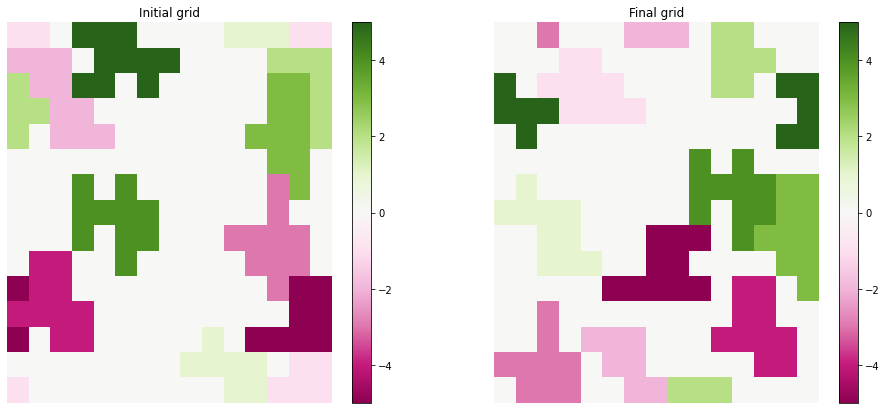

<Figure size 1152x504 with 0 Axes>

CPU times: user 3.07 s, sys: 4 ms, total: 3.07 s
Wall time: 3.06 s


In [ ]:
# Defining necessary constants
L = 10
M = 5
T = 200
N = 15
max_iter = 30000
rigid_grid = generate_grid_of_polymers(N,M,L)
final_grid, e_rigid = monte_carlo_polymer(rigid_grid,max_iter, T, polymer_rigid_move)

plt.rcParams["figure.figsize"] = (16,7)
plt.subplot(1,2,1)
visualize_grid(rigid_grid,"Initial grid",1,2)
plt.subplot(1,2,2)
visualize_grid(final_grid,"Final grid",2,2)
plt.show()
%time e = monte_carlo_polymer(rigid_grid,50000,T,polymer_rigid_move)


The two grids shows a system of polymers before and after 30000 iterations using the rigid move function. We can see that the system has started forming clusters and several of the polymers are completely gridlocked. However they are not tightly packed together, as the rigid_move function does not allow moves that changes the geometry of the polymer.

There are several factors that increase the runtime of polymers vs monomers. One of them is the fact that you now have to check multiple neighbouring cells if it is possible to move there, as opposed to for monomers where you only have to check the single cell the monomer is moving to. Additionally the move itself also takes up more computational power. Which in turn increases the run time. However the code we have written is equally efficent and therefore there is a negliegeble difference in run time, when tested at the same amount of iterations.

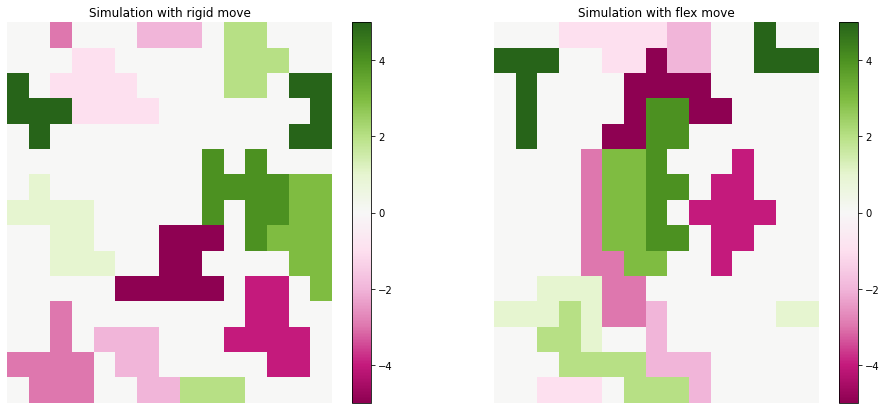

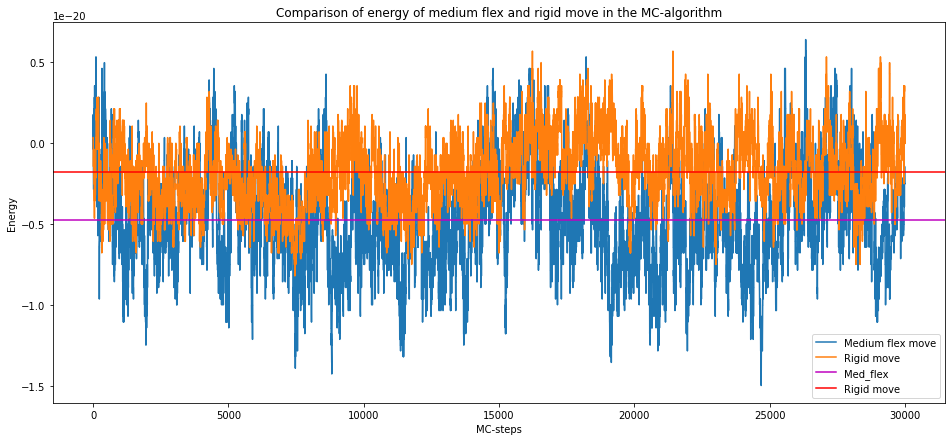

In [ ]:
final_grid_flex, e_medium_flex = monte_carlo_polymer(rigid_grid,max_iter, T, polymer_medium_flex_move)
plt.rcParams["figure.figsize"] = (16,7)
plt.subplot(1,2,1)
visualize_grid(final_grid,"Simulation with rigid move",1,2)
plt.subplot(1,2,2)
visualize_grid(final_grid_flex,"Simulation with flex move",1,2)
plt.show()

plt.figure(2)
plt.title("Comparison of energy of medium flex and rigid move in the MC-algorithm")
plt.plot(e_medium_flex, label = "Medium flex move")
plt.plot(e_rigid, label = "Rigid move")
plt.axhline(np.mean(e_medium_flex),xmin = 0,xmax = 1, color = 'm',label = "Med_flex")
plt.axhline(np.mean(e_rigid),xmin = 0,xmax = 1,color = 'r',label = "Rigid move")
plt.xlabel("MC-steps")
plt.ylabel("Energy")
plt.legend()
plt.show()




The main difference between the rigid move and the medium flex move is that the flex move allows the polymers to wrap tighter, increasing the number of contact points. This is clearly visible when you compare the two grids, as the mean energy of the medium flex move system is generally lower than the rigid move system. What is also visible from the energy plots is the much larger fluctuations in the medium flex move, which has both higher and lower extremums. From the visualized grids we can see that the polymers wraps around each other in the medium flex move function. The polymers also have a tendency to stretch out and become elongated which gives the polymer an increased number of connectivity points. This will result in more violent energy fluctuations, which is well represented in the corresponding energy plot.

### The clustering of polymers
Much like the forming of clusters among the monomer in earlier simulations, we can also look at clustering in a simulation of polymers. Since polymers are so much more structurally complex than monomers, it might be rarer for polymers to cluster together and at the same time reach a energy minima. We will now look into the clustering as a function of the multivalency of the polymers and discuss these results.

In [ ]:
@njit
def poly_cluster_per_multivalency(max_iter,grid_size,polymers,mvalency_low,mvalency_high,step_size,measurements,mvalency_number,temperature):
    """
    max_iter: Number of simulation steps before equilibrium.
    grid_size: Size of the grid.
    polymers: Number of positive/negative polymers.
    mvalency_low: The lowest multivalency in the simulation.
    mvalency_high: The highest multivalency in the simulation.
    step_size: Number of simulation steps between each measurement after equilibrium.
    measurements: Number of measurements after equilibrium.
    mvalency_number: Number of multivalencies measured.

    For each multivalency the function will simulate the system by first reaching equilibrium, then taking all the measurements
    between the simulation steps. Once again the mean of the mean value of the cluster sizes are used and returned.
    
    Return: An array with the mean of the mean cluster sizes for each distinct multivalency simulation, the standard deviation and an array with the number of clusters in the system.
    """
    mvalency_interval = (mvalency_high-mvalency_low)//(mvalency_number-1) # Finding the distance between each multivalency
    cluster_per_mvalency = np.zeros(mvalency_number, dtype=np.dtype('f'))
    stdev_of_cluster = np.zeros(mvalency_number, dtype=np.dtype('f'))
    cluster_number = np.zeros(mvalency_number, dtype=np.dtype('f'))

    for i in range(mvalency_number):
        multivalency = mvalency_low + i*mvalency_interval # The current multivalency
        grid = generate_grid_of_polymers(grid_size,polymers,multivalency) # Fresh grid of polymers
        clusters = np.zeros(measurements+1, dtype=np.dtype('f'))
        grid, energies = monte_carlo_polymer(grid,max_iter,temperature,polymer_medium_flex_move) # Run to reach equilibrium state
        clustered_grid = cluster_grid(grid)
        clusters[0] = np.mean(cluster_size(clustered_grid)) # The mean of the cluster size after reaching equilibrium
        for n in range(1,measurements+1):
            grid, energies = monte_carlo_polymer(grid,step_size,temperature,polymer_medium_flex_move) # Monte carlo simulation for each measurement
            clustered_grid = cluster_grid(grid) # Clustering in a measurement
            clusters[n] = np.mean(cluster_size(clustered_grid)) # Adding the mean to an array
        cluster_per_mvalency[i] = np.mean(clusters)/multivalency # Taking the mean of the mean cluster sizes for this iterations multivalency
        stdev_of_cluster[i] = np.std(clusters)/multivalency
        cluster_number[i] = np.max(clustered_grid)
    return cluster_per_mvalency, stdev_of_cluster, cluster_number

In [ ]:
cp2, stdev2,nco2 = poly_cluster_per_multivalency(10000,30,5,3,39,1000,100,13,500)

In [ ]:
# Defining necessary variables
T = 300
t_r = 1000
N = 30
M = 5
L_l = 3
L_h = 39
n = 100

cpm, stdev_cpm, noc = poly_cluster_per_multivalency(10000,N,M,3,39,t_r,n,13,T)

%time r,a = poly_cluster_per_multivalency(10000,N,M,L_l,L_h,t_r,n,13,T)



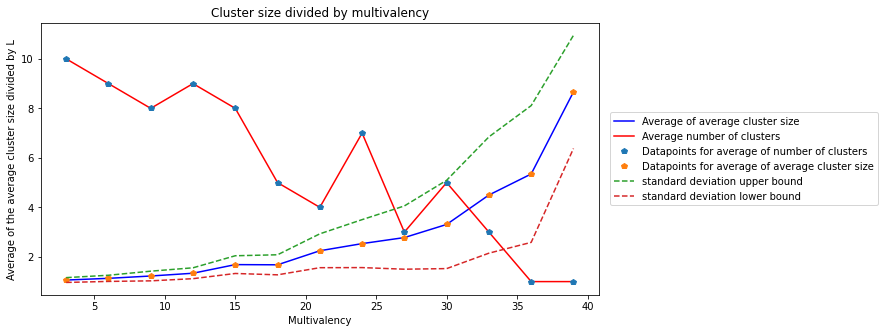

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
x_values = np.linspace(3,39,13)
plt.plot(x_values,cpm,'b',label = "Average of average cluster size")
plt.plot(x_values,noc,'r',label = "Average number of clusters")
plt.plot(x_values,noc,'p',label = "Datapoints for average of number of clusters")
plt.plot(x_values,cpm,'p',label = "Datapoints for average of average cluster size")
plt.plot(x_values, cpm + stdev_cpm,'--', label = "standard deviation upper bound")
plt.plot(x_values,cpm - stdev_cpm,'--',label = "standard deviation lower bound")
plt.title("Cluster size divided by multivalency")
plt.xlabel("Multivalency")
plt.ylabel("Average of the average cluster size divided by L")
plt.legend(bbox_to_anchor=(1.5,0.5), loc="center right", borderaxespad=0)
plt.show()




In the plot and simulation above we have chosen $t_{equil} = 10000$ and $n = 100$. From the plot comparing the energy development in a system using monte carlo with rigid or medium flex move, it is safe to assume that the system reaches equilibrium almost immediately. Therefore we prioritize getting as many measurements(n) as our computational power allows us. 

The average size of the clusters $\langle d \rangle$ increase with the increase in multivalency and therefore $\langle d \rangle$ divided by $L$ increases. The reasoning behind choosing the average of the average is the same as for the corresponding plot for monomer systems. When the multivalency increases the polymers abillity to stretch and the number of connectivity points increase. In addition the polymers themselves get longer, and therefore the likelhood of forming large clusters increase, because each polymer contributes a larger and larger number of monomers to each cluster.

This is backed up by the graph for $\langle m \rangle$  where we see the average number of clusters decreasing when we increase the multivalency. This is because the grid gets more densely packed with polymers and the probability of forming large clusters therefore increases. 

Using the rigid move instead of the medium flexible move would increase the amount of total clusters, but decrease the size of the clusters since they lack the ability to pack tightly and make room for more polymers wanting to join the clusters.

For larger values of multivalency the effect one polymer connecting or disconnecting to a cluster has is more impactful. This is reflected by the large increase in uncertainty illustrated by the dotted lines. Which is why we can expect the results to vary the most. 

If we increase the temperature in the system the probability of a polymer moving even though it is not energeticly favourable increases, however the clustering is still largely dependent on the area of the grid and the amount of polymers. Therefore, as multivalency rises,  the effect temperature has on the system is less and less impactful. However if you increase the N, grid size, in unison with raising the temperature. The formation of clusters are less frequent.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=62874dcd-5630-4b7b-ac5d-ec5356686ccf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>